# Dimensionality reduction with LDA

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sekhansen/text_algorithms_econ/blob/main/notebooks/3_LDA.ipynb)


This notebook introduces how to use the [```lda```](https://lda.readthedocs.io/en/latest/autoapi/lda/index.html) Python library for estimating Latent Dirichlet Allocation using the collapsed Gibbs sampling algorithm of Griffiths and Steyvers (2004).

To illustrate LDA, the tutorial uses two different data sources: 
1. Text data from State of the Union Addresses at the paragraph level. These are available for download from [this link](http://www.presidency.ucsb.edu/sou.php).
2. Text data from minutes from the [Monetary Policy Committee](https://www.bankofengland.co.uk/about/people/monetary-policy-committee) meetings at the Bank of England. You can browse through all of these minutes [here](https://www.bankofengland.co.uk/monetary-policy-summary-and-minutes/monetary-policy-summary-and-minutes).

In [85]:
# install required libraries
!pip3 install flashtext                  # easy phrase replacing methods
!pip3 install contractions               # expand English contractions
!pip3 install spacy                      # functions for lemmatizing
!pip3 install gdown                      # download files from Google Drive
!pip3 install nltk                       # NLP library
!pip3 install lda                        # LDA library
!pip3 install wordcloud                  # library for wordclouds

# install Spacy's language model
# for more languages and models check: https://spacy.io/models
!python3 -m spacy download en_core_web_sm

In [ ]:
# clone the GitHub repository with the preprocessing scripts
!git clone https://github.com/unstructured-data-research/text-preprocessing

Cloning into 'pymodules-test'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 41 (delta 13), reused 32 (delta 9), pack-reused 0
Unpacking objects: 100% (41/41), done.


In [ ]:
# define dictionary with paths to data and Python scripts in Google Drive
urls_dict = {"speech_data_extend":          ("https://drive.google.com/uc?id=1O8wy8vbOY8TXYze27b_dAkB9UOq8BNy_", "txt"),
             "mpc_minutes":                 ("https://drive.google.com/uc?id=1k086m12gBHKuVMPv4GUD1aB_kZOZpznR", "txt")
             }

In [ ]:
# download all files
import gdown
for file_name, attributes in urls_dict.items():
    url = attributes[0]
    extension = attributes[1]
    gdown.download(url, f"./{file_name}.{extension}", quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1O8wy8vbOY8TXYze27b_dAkB9UOq8BNy_
To: /content/speech_data_extend.txt
100%|██████████| 12.1M/12.1M [00:00<00:00, 72.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1k086m12gBHKuVMPv4GUD1aB_kZOZpznR
To: /content/mpc_minutes.txt
100%|██████████| 7.36M/7.36M [00:00<00:00, 43.4MB/s]


In [ ]:
# import required libraries
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import lda

import spacy
nlp_standard = spacy.load('en_core_web_sm')

# import our own modules
sys.path.append('./text-preprocessing/src')
import preprocessing_class as pc
import preprocess_data

# State of the Union Addresses

To begin, we read in the data, specifying the encoding of the text data.

In [ ]:
data = pd.read_table("speech_data_extend.txt", encoding="utf-8")
data

,president,speech,year
0,Washington,Fellow-Citizens of the Senate and House of Rep...,1790
1,Washington,I embrace with great satisfaction the opportun...,1790
2,Washington,In resuming your consultations for the general...,1790
3,Washington,Among the many interesting objects which will ...,1790
4,Washington,"A free people ought not only to be armed, but ...",1790
...,...,...,...
23150,Obama,Let me tell you about one of those families I'...,2014
23151,Obama,"A few months later, on his 10th deployment, Co...",2014
23152,Obama,"Even now, Cory is still blind in one eye, stil...",2014
23153,Obama,"My fellow Americans, men and women like Cory r...",2014


For the tutorial we focus on State of the Union addresses made since the television era, which began in 1947.

In [ ]:
data = data[data.year >= 1947]
data.reset_index(drop=True, inplace=True)
len(data) # The number of documents (paragraphs of State of the Union Addresses) in the dataset

9488

## Cleaning Raw Text Data

Before implementing a topic model, it is important to pre-process the data. To do this, we will use a custom-built preprocessing Python library. For a more detailed discussion on preprocessing check the *2_preprocessing.ipynb* notebook within this same repository.

We will start by creating a function that applies all the preprocessing steps in the correct order. We should provide the documents that we want to preprocess along side some key parameters. The function will return an object ```prep``` that we will use to later create a document-term matrix.


In [ ]:
def apply_preprocessing(data, item_type, stopwords_type, replacing_dict, pattern, punctuation):
    """ Function to apply the steps from the preprocessing class in the correct
        order to generate a term frequency matrix
    """

    # initialize the class with the text data and some parameters
    prep = pc.RawDocs(data)

    # replace some specific phrases of interest
    prep.phrase_replace(replace_dict=replacing_dict, 
                        sort_dict=True,
                        case_sensitive_replacing=False)
    
    # lower-case text and expand contractions
    prep.basic_cleaning(lower_case=True,
                        contraction_split=True)

    # split the documents into tokens
    prep.tokenize_text(tokenization_pattern=pattern)

    # clean tokens (remove non-ascii characters, remove short tokens, remove punctuation and numbers)
    prep.token_clean(length=1, 
                    punctuation=punctuation, 
                    numbers=True)

    # remove stopwords
    if item_type == "tokens":
        prep.stopword_remove(items='tokens', stopwords="short")
    elif item_type == "lemmas":
        prep.lemmatize()
        prep.stopword_remove("lemmas", stopwords=stopwords_type)
    elif item_type == "stems":
        prep.stem()
        prep.stopword_remove("stems", stopwords=stopwords_type)

    return prep

In [ ]:
# define tokenization pattern and punctuation symbols
pattern = r"(?u)\b\w\w+\b"
punctuation = string.punctuation.replace("-", "")

In [ ]:
# use preprocessing class
prep = apply_preprocessing(data["speech"],       # our documents
                           "stems",              # tokens, stems or lemmas
                           "long",               # long or short
                           {},                   # dictionary with expressions we want to preserve
                           pattern,              # tokenization pattern
                           punctuation           # string with punctuation symbols to remove
                           )

In [ ]:
# inspect a particular document and compare it to its original form
i = 1008
print(data["speech"][i])
print("\n ------------------------------- \n")
print(prep.stems[i])

Since our hope is peace, we owe ourselves and the world a candid explanation of the military measures we are taking to make that peace secure. 

 ------------------------------- 

['hope', 'peac', 'owe', 'world', 'candid', 'explan', 'militari', 'measur', 'peac', 'secur']


Notice that the outcome of stemming need not be an English word.  These stems are the data on which we will run the topic model below.

The final step in pre-processing is to drop remaining words that are not useful for identifying content.  We have already dropped standard stopwords, but there may also be data-dependent common words.  For example, in data from Supreme Court proceedings, "justice" might be treated as a stopword.  Also, words that appear just once or twice in the collection are not informative of content either.  Ideally, one would like a measure of informativeness that both punishes common words in the data, and rare words.  One such option is to give each stem a tf-idf (term frequency - inverse document frequency) score.  This is standard in the language processing literature, so we omit details here.

In [ ]:
# generate document frequency ranking for stems
prep.get_term_ranking("stems", score_type="df")

In [ ]:
# explore top stems
prep.df_ranking["stems"][0:10]

[(3072.0, 'will', 0),
 (2323.0, 'year', 1),
 (2063.0, 'nation', 2),
 (1584.0, 'american', 3),
 (1484.0, 'can', 4),
 (1484.0, 'peopl', 4),
 (1479.0, 'must', 5),
 (1460.0, 'congress', 6),
 (1307.0, 'world', 7),
 (1283.0, 'work', 8)]

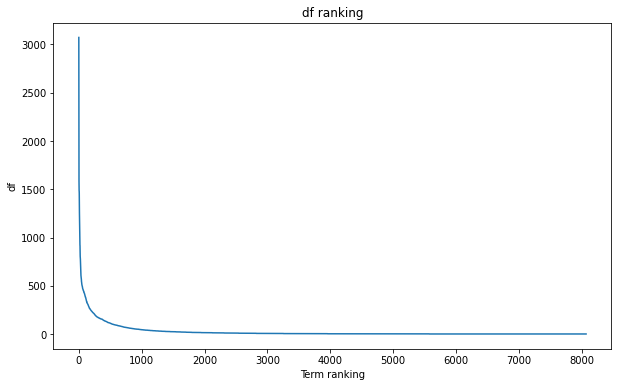

In [ ]:
# plot df ranking
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in prep.df_ranking["stems"]])
plt.title('df ranking')
plt.ylabel("df")
plt.xlabel("Term ranking")
plt.show()

In [ ]:
# generate term frequency inverse document frequency ranking of stems
prep.get_term_ranking("stems", score_type="tfidf")

In [ ]:
# explore top stems
prep.tfidf_ranking["stems"][0:10]

[(29.20437813202517, 'solar', 0),
 (29.130874070445277, 'gun', 1),
 (28.97939622157289, 'mental', 2),
 (28.748634832223622, 'iraqi', 3),
 (28.703514876124355, 'indian', 4),
 (28.615629090288202, 'refuge', 5),
 (28.32173833386689, 'sugar', 6),
 (28.132455763529922, 'mr', 7),
 (28.030896730951184, 'space', 8),
 (27.870672802620213, 'railroad', 9)]

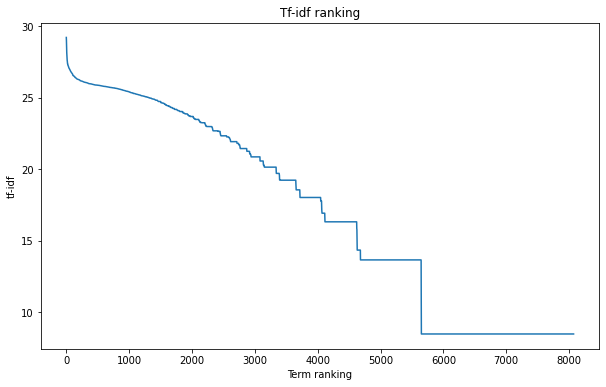

In [ ]:
# plot tfidf ranking
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in prep.tfidf_ranking["stems"]])
plt.title('Tf-idf ranking')
plt.ylabel("tf-idf")
plt.xlabel("Term ranking")
plt.show()

At this stage, the user can decide how many stems to drop based on either the df or tf-idf scores.  The first argument to rank_remove defines whether to drop from "tokens" or "stems" (since we formed the rankings based on stems above, we should specify stems) and the second specifies the ranking method to use ("df" or "tfidf"). Finally, you can either provide a *min_cutoff_value* which will remove all items with a score below the value or a *max_cutoff_value* which will remove all items with a score above the value.

One can determine the cutoffs from exploring rankings that we have already created. Here we plot the ranking in Python, which indicates a reasonable cutoff minimum cutoff around the term in position 5,000.

In [ ]:
# remove stems with a tfidf score equal or lower than the score of stem 5,000
cutoff_score = prep.tfidf_ranking["stems"][5000][0]
cutoff_score

13.645362372815821

In [ ]:
# apply removal
prep.rank_remove("stems", "tfidf", min_cutoff_score=cutoff_score)

In [ ]:
# create document-term matrix using stems
prep.dt_matrix_create(items='stems', score_type='df')
# extract document-term matrix
dt_matrix_stems = prep.df_matrix["stems"].astype(int)
print(dt_matrix_stems.shape)

(9488, 4680)


In [ ]:
# get the vocabulary and the appropriate dictionaries to map from indices to words
word2idx = prep.vocabulary["stems"]
idx2word = {i:word for word,i in word2idx.items()}

In [ ]:
all_stems = [s for d in prep.stems for s in d]
print("number of unique stems = %d" % len(set(all_stems)))
print("number of total stems = %d" % len(all_stems))

number of unique stems = 4680
number of total stems = 250204


After pre-processing, we have 4,680 unique stems We now proceed to estimate a topic model on them.

## Estimating a Topic Model

The first step in estimation is to initialize a model using the LDA class.  We will pass the list of stems we just created as the set of documents.

There are three main parameters in LDA, the number of topics, and the two hyperparameters of the Dirichlet priors.  We will follow the advice of Griffiths and Steyvers (2004) and set the hyperparameter of the Dirichlet prior on topics to $200/V$, where $V$ is the number of unique vocabulary elements, and the hyperparameter of the Dirichlet prior on document-topic distributions to $50/K$, where $K$ is the number of topics.

In [ ]:
# create LDA object with our parameters
num_topics = 30
vocab_size = dt_matrix_stems.shape[1]
lda_model = lda.LDA(n_topics=num_topics,         # Number of topics
                    alpha=50/num_topics,         # Dirichlet parameter for distribution over topics
                    eta=200/vocab_size,          # Dirichlet parameter for distribution over words
                    n_iter=5000,                 # Number of sampling iterations
                    random_state=92              # The generator used for the initial topics
                    )

lda_model

In [ ]:
# check some paramters
print(lda_model.alpha)
print(lda_model.eta)
print(lda_model.n_topics)

1.6666666666666667
0.042735042735042736
30


In [ ]:
# estimate model (takes around 7 minutes)
lda_model.fit(dt_matrix_stems)

The estimated topics are represented by a $30 \times 4680$ matrix whose rows sum to one, while the estimated distributions of topics within each document are represented by $9488 \times 30$ matrices whose rows sum to one as well.  To get an idea of the topics that have been estimated, and whether they make sense, we will explore the stems with the highest probability for each topic. It's a good idea to check the topics are "reasonable" before proceeding with any analysis.

In [ ]:
# topics: probability distribution over the vocabulary (num_topics x vocab_size)
lda_model.topic_word_.shape

(30, 4680)

In [ ]:
# explore the words with highest probability per topic
topics_dist = lda_model.topic_word_
n_top_words = 15
for i, topic_dist in enumerate(topics_dist):
    top_idxs = np.argsort(topic_dist)[:-n_top_words:-1]
    top_words = [idx2word[idx] for idx in top_idxs]
    print('Topic {}: {}'.format(i, ' '.join(top_words)))

Topic 0: budget increas billion spend million deficit balanc dollar next percent reduc number fiscal near
Topic 1: countri men serv fight women america home terrorist iraq lead across thousand terror attack
Topic 2: need problem meet face challeng serious deal basic concern address term approach ahead question
Topic 3: health care system social cost benefit insur welfar secur provid servic plan need medic
Topic 4: govern respons must share interest determin upon purpos decis individu hold cours success self
Topic 5: time america chang great histori come futur centuri look today generat challeng dream call
Topic 6: job busi creat help privat employ invest worker work small encourag unemploy opportun train
Topic 7: can must cannot without mean togeth believ abl becom sure futur possibl longer confid
Topic 8: resourc protect land area natur water use project preserv environ environment control develop public
Topic 9: presid tonight day ago member american thank congress mr th honor ask fe

In [ ]:
# prepare Wordcloud with top words from some topics
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
n_top_words = 15
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=n_top_words,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

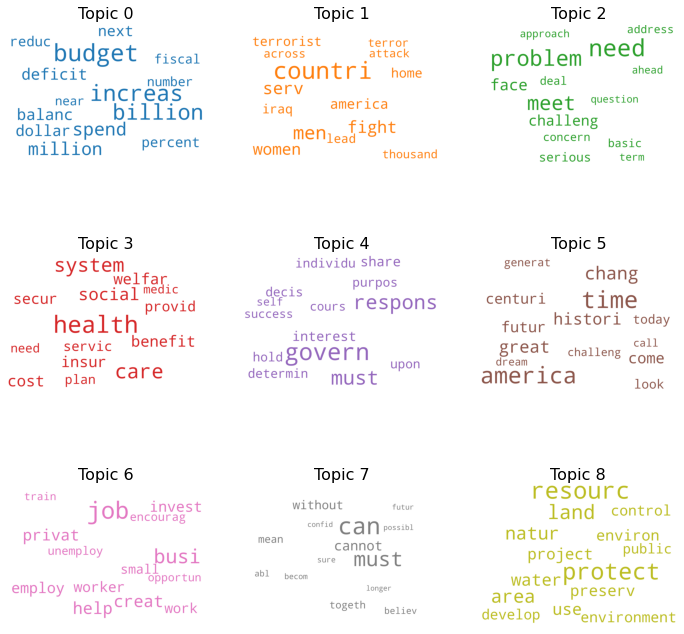

In [ ]:
# create figure for 9 topics
fig, axes = plt.subplots(3, 3, figsize=(12,12), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    
    # select top words from topic
    topic_dist = topics_dist[i]
    top_idxs = np.argsort(topic_dist)[:-n_top_words:-1]
    top_words = [idx2word[idx] for idx in top_idxs]
    top_probs = [topic_dist[idx] for idx in top_idxs]
    plot_dict = {top_words[i]:top_probs[i] for i in range(len(top_words))}

    # generate subplot    
    fig.add_subplot(ax)
    cloud.generate_from_frequencies(plot_dict, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

Most economics researchers will probably be most interested initially in the distributions of topics within each document.

In [ ]:
# matrix of proportion of topics per document (num_doc x num_topics)
lda_model.doc_topic_.shape

(9488, 30)

One might also want to replace the speech field in the original dataset with the estimated topics in order to have a ready-to-go dataset for regression or other econometric analysis.  The following code builds this dataset, and also writes it to file.

In [ ]:
# add the topic proportions to each document
for i in range(lda_model.doc_topic_.shape[1]): data['T' + str(i)] = lda_model.doc_topic_[:,i]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# explore our new data
data.head(2)

,president,speech,year,T0,T1,T2,T3,T4,T5,T6,...,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29
0,Truman,"Mr. President, Mr. Speaker, Members of the Con...",1947,0.028736,0.028736,0.028736,0.028736,0.028736,0.028736,0.028736,...,0.028736,0.028736,0.028736,0.028736,0.028736,0.028736,0.028736,0.063218,0.028736,0.028736
1,Truman,It looks like a good many of you have moved ov...,1947,0.030303,0.030303,0.030303,0.030303,0.030303,0.048485,0.030303,...,0.030303,0.066667,0.030303,0.030303,0.030303,0.030303,0.066667,0.030303,0.030303,0.030303


In [ ]:
# save data
data.to_csv("final_output.csv", index=False)

## Querying Using Estimated Topics

After estimating a topic model, one is often interested in estimating the distribution of topics for documents not included in estimation.  In this case, one option is to $\textit{query}$ those documents by holding fixed the topics estimated from LDA, and only estimating the distribution of topics for the out-of-sample documents.  The ```lda``` library also provides a way to do this through the ```transform()``` function.

We will apply querying to the corpus of entire State of the Union Addresses since 1947 (recall that we estimated topics on the level of the paragraph within each speech).  In terms of estimating topics, the paragraph level is preferable to the speech level since individual paragraphs are more likely to be based around a single theme.  But, in terms of econometric work, the entire speech is a more natural unit of analysis.  At the same time, there is no general way of "adding up" probability distribution at the paragraph level in order to arrive at a speech-level distribution.  Hence the need for querying, which allows us to estimate the speech-level distributions.

In [ ]:
# replace the speech field in the original data with its cleaned and stemmed version
data['speech_stems'] = [' '.join(s) for s in prep.stems] 

# aggregate up to the year-speech level using the stemmed version of the speech
agg_speeches = data.groupby(['year','president'], as_index = False)['speech_stems'].apply(lambda x: ' '.join(x)) 
agg_speeches

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,year,president,speech_stems
0,1947,Truman,mr presid mr speaker member congress unit stat...
1,1948,Truman,mr presid mr speaker member th congress today ...
2,1949,Truman,mr presid mr speaker member congress happi rep...
3,1950,Truman,mr presid mr speaker member congress ago repor...
4,1951,Truman,mr presid mr speaker member congress congress ...
...,...,...,...
66,2010,Obama,madam speaker vice presid biden member congres...
67,2011,Obama,mr speaker mr vice presid member congress dist...
68,2012,Obama,mr speaker mr vice presid member congress dist...
69,2013,Obama,pleas everybodi seat mr speaker mr vice presid...


In [ ]:
# simple auxiliary function to override the preprocessing done by sklearn
def do_nothing(doc):
    return doc

# generate document-term matrix of agreggated speeches
count_vectorizer = CountVectorizer(preprocessor=do_nothing,              # apply no additional preprocessing
                                   token_pattern=pattern,                # use same tokenization pattern
                                   lowercase=False,                      # convert all characters to lower-case
                                   strip_accents=None,                   # remove non-ascii characters
                                   stop_words=None,                      # remove stopwords from a built-in list. We can also provide our own list
                                   vocabulary=word2idx                   # impose same vocabulary
                                   )                       
count_vectorizer

CountVectorizer(lowercase=False,
                preprocessor=<function do_nothing at 0x7fb012366170>,
                vocabulary={'aaron': 0, 'abandon': 1, 'abat': 2, 'abid': 3,
                            'abil': 4, 'abl': 5, 'abolish': 6, 'abolit': 7,
                            'abort': 8, 'abraham': 9, 'abreast': 10,
                            'abroad': 11, 'absenc': 12, 'absolut': 13,
                            'absorb': 14, 'abstin': 15, 'absurd': 16,
                            'abund': 17, 'abus': 18, 'academ': 19,
                            'academi': 20, 'acceler': 21, 'accept': 22,
                            'access': 23, 'accid': 24, 'accident': 25,
                            'accommod': 26, 'accompani': 27, 'accomplish': 28,
                            'accord': 29, ...})

In [ ]:
# create the document-term matrix using stems
dt_matrix_stems_agg = count_vectorizer.fit_transform(agg_speeches["speech_stems"].values).toarray()
print(dt_matrix_stems_agg.shape)

(71, 4680)


In [ ]:
# extract the vocabulary
vocab_agg = count_vectorizer.vocabulary_

Before continuing, suppose that we instead wanted to query a document whose constitutent parts had not been included in estimation, for example a State of the Union Address from the 1930s.  How to proceed?  First, create a RawDocs object with the text to be queried (recall that RawDocs can take a basic text file, which each new line treated as a separate documents).  Second, perform the same cleaning steps as were done for the documents that went into the estimated model.  However, there is no need to do any stopword removal.  When you initialize a Query object, tokens in the documents to be queried that are not present in the estimated model are automatically stripped out.

Since we don't need to estimate topics when querying, we can use far fewer iterations.  Let's start with 10.

In [ ]:
# transform documents into their topic proportions
topic_proportions = lda_model.transform(dt_matrix_stems_agg,
                                        max_iter=20
                                        )
topic_proportions.shape

(71, 30)

Finally, we follow similar steps as for LDA to output the estimated distribution of topics for entire speeches.

In [ ]:
# add the topic proportions to each document
for i in range(topic_proportions.shape[1]): agg_speeches['T' + str(i)] = topic_proportions[:,i]

In [ ]:
# explore new data
agg_speeches.head(5)

,year,president,speech_stems,T0,T1,T2,T3,T4,T5,T6,...,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29
0,1947,Truman,mr presid mr speaker member congress unit stat...,0.025571,0.021181,0.035705,0.035402,0.055626,0.012905,0.029946,...,0.047553,0.030652,0.070136,0.080987,0.028284,0.014580,0.011332,0.049454,0.019829,0.079242
1,1948,Truman,mr presid mr speaker member th congress today ...,0.024548,0.019387,0.035037,0.044291,0.055166,0.027295,0.020584,...,0.006574,0.049547,0.043173,0.039561,0.029159,0.015968,0.018529,0.042989,0.016477,0.076161
2,1949,Truman,mr presid mr speaker member congress happi rep...,0.012382,0.009399,0.019031,0.057703,0.050001,0.026506,0.035872,...,0.022410,0.034292,0.044138,0.043623,0.028564,0.014823,0.023583,0.040858,0.004136,0.090130
3,1950,Truman,mr presid mr speaker member congress ago repor...,0.024794,0.017718,0.023081,0.038586,0.045013,0.037584,0.022882,...,0.009402,0.052454,0.037058,0.040830,0.027284,0.020901,0.015966,0.037592,0.015426,0.062673
4,1951,Truman,mr presid mr speaker member congress congress ...,0.004075,0.035082,0.038819,0.020062,0.024385,0.014542,0.016281,...,0.001038,0.035207,0.042292,0.030633,0.016365,0.019933,0.011810,0.031317,0.090631,0.039404


In [ ]:
# save data
agg_speeches.to_csv("final_output_agg.csv", index=False)

## Assessing Output

At this point, you can use all of the csv files this tutorial has generated with your statistical software of choice (should this not be Python!) to analyze the topics.  Before finishing, though, we can perform an initial test of whether our output makes sense intuitively.  The following code determines each President's top topics, as measured in terms of deviations from the sample average.

In [ ]:
temp = agg_speeches.reset_index(drop=True).copy()
ranking = temp.set_index('president')
ranking = ranking - ranking.mean()
ranking = ranking.groupby(level='president').mean()
ranking

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


,T0,T1,T10,T11,T12,T13,T14,T15,T16,T17,...,T28,T29,T3,T4,T5,T6,T7,T8,T9,year
president,,,,,,,,,,,,,,,,,,,,,
BushI,-0.001728,-0.002768,-0.004213,0.036505,-0.009258,-0.012152,0.013631,-0.003369,-0.000264,0.020891,...,-0.000550,-0.015290,-0.006607,-0.007178,0.020449,0.002375,0.006818,-0.007477,0.023991,10.65493
BushII,-0.010335,0.098158,-0.012837,-0.004431,-0.010933,-0.001864,-0.006653,0.012937,0.007668,0.004208,...,-0.005781,-0.016849,0.018797,-0.006697,-0.001117,-0.003121,-0.006544,-0.015514,0.013501,24.65493
Carter,-0.004202,-0.029682,0.006277,-0.036356,0.034822,0.032035,-0.015527,-0.002301,-0.019988,-0.030007,...,0.022344,0.011464,0.003771,-0.013300,-0.026949,0.000981,-0.019062,0.011396,-0.031702,-0.34507
Clinton,-0.001094,-0.010986,-0.019032,0.036352,-0.014253,0.006150,0.042656,-0.007873,0.002462,-0.013347,...,-0.013604,-0.016684,0.020222,-0.008794,0.008802,0.011596,0.007882,-0.006079,0.017622,16.65493
Eisenhower,-0.002259,-0.026129,0.035618,-0.030012,0.018504,-0.007365,-0.022726,0.005223,-0.010720,0.006590,...,0.003400,0.019128,-0.005407,0.019081,-0.016751,-0.012668,-0.006606,0.005836,-0.027827,-22.84507
Ford,0.015434,-0.020104,0.009606,-0.013973,0.006695,0.001205,-0.012249,-0.005647,-0.003078,-0.014890,...,0.003828,0.000823,-0.013940,0.007043,-0.004662,-0.010025,-0.002464,-0.007080,0.009708,-3.84507
JohnsonII,0.005686,-0.001673,-0.009039,-0.004407,-0.004617,0.007022,0.010077,0.003126,0.013012,-0.008166,...,0.018473,-0.006969,-0.008966,-0.003575,-0.004053,-0.006942,0.007703,0.000625,0.010046,-13.34507
Kennedy,0.012488,-0.012478,0.017241,-0.027918,0.006203,-0.009541,-0.013206,0.015283,-0.012962,0.010145,...,0.028167,0.021627,-0.006833,0.001843,-0.011993,-0.005949,-0.001834,-0.000056,-0.009807,-17.84507
Nixon,0.000190,-0.026816,-0.012935,-0.016032,0.009832,0.008087,-0.008880,-0.012674,0.011224,-0.017558,...,-0.019193,0.005847,-0.008863,0.009342,0.016615,-0.011220,-0.001070,0.049843,-0.014730,-7.84507


In [ ]:
# sort presidents chronologically
ranking = ranking.sort_values('year')
ranking = ranking.drop('year', 1)
ranking

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,T0,T1,T10,T11,T12,T13,T14,T15,T16,T17,...,T27,T28,T29,T3,T4,T5,T6,T7,T8,T9
president,,,,,,,,,,,,,,,,,,,,,
Truman,-0.017902,-0.014065,0.017398,-0.013048,0.003584,-0.008525,-0.014826,0.014984,-0.001076,0.026038,...,0.007594,0.010829,0.030655,-0.001101,0.008454,-0.013212,-0.009662,0.004375,0.006285,-0.022984
Eisenhower,-0.002259,-0.026129,0.035618,-0.030012,0.018504,-0.007365,-0.022726,0.005223,-0.010720,0.006590,...,0.009318,0.003400,0.019128,-0.005407,0.019081,-0.016751,-0.012668,-0.006606,0.005836,-0.027827
Kennedy,0.012488,-0.012478,0.017241,-0.027918,0.006203,-0.009541,-0.013206,0.015283,-0.012962,0.010145,...,0.008848,0.028167,0.021627,-0.006833,0.001843,-0.011993,-0.005949,-0.001834,-0.000056,-0.009807
JohnsonII,0.005686,-0.001673,-0.009039,-0.004407,-0.004617,0.007022,0.010077,0.003126,0.013012,-0.008166,...,-0.002328,0.018473,-0.006969,-0.008966,-0.003575,-0.004053,-0.006942,0.007703,0.000625,0.010046
Nixon,0.000190,-0.026816,-0.012935,-0.016032,0.009832,0.008087,-0.008880,-0.012674,0.011224,-0.017558,...,-0.000130,-0.019193,0.005847,-0.008863,0.009342,0.016615,-0.011220,-0.001070,0.049843,-0.014730
Ford,0.015434,-0.020104,0.009606,-0.013973,0.006695,0.001205,-0.012249,-0.005647,-0.003078,-0.014890,...,0.010068,0.003828,0.000823,-0.013940,0.007043,-0.004662,-0.010025,-0.002464,-0.007080,0.009708
Carter,-0.004202,-0.029682,0.006277,-0.036356,0.034822,0.032035,-0.015527,-0.002301,-0.019988,-0.030007,...,0.020043,0.022344,0.011464,0.003771,-0.013300,-0.026949,0.000981,-0.019062,0.011396,-0.031702
Reagan,0.018895,-0.011962,-0.005180,0.008027,-0.006774,-0.004667,-0.002380,-0.008868,0.006318,0.015888,...,-0.001799,-0.008052,-0.008917,-0.012244,-0.002814,0.017750,-0.001698,0.003990,-0.010971,0.020085
BushI,-0.001728,-0.002768,-0.004213,0.036505,-0.009258,-0.012152,0.013631,-0.003369,-0.000264,0.020891,...,-0.005334,-0.000550,-0.015290,-0.006607,-0.007178,0.020449,0.002375,0.006818,-0.007477,0.023991


In [ ]:
def get_top_topics(x, num_top, col_names):
    top_idxs = x.values.argsort()[-num_top:][::-1]
    top_topics = [int(col_names[i].replace("T", "")) for i in top_idxs]
    return pd.Series(top_topics, index=range(1,num_top+1))

In [ ]:
# find the most prevalent topics for each president
ranking_top = ranking.apply(get_top_topics, num_top=10, col_names=ranking.columns, axis=1)
ranking_top

,1,2,3,4,5,6,7,8,9,10
president,,,,,,,,,,
Truman,29,17,10,15,21,23,22,28,4,27
Eisenhower,10,22,29,4,12,20,24,27,23,17
Kennedy,28,29,10,15,19,0,17,27,12,21
JohnsonII,28,22,16,14,9,21,7,13,0,24
Nixon,8,24,5,2,20,22,21,16,12,4
Ford,25,0,19,18,27,24,9,10,4,12
Carter,20,24,12,13,28,25,27,23,29,8
Reagan,9,0,18,5,17,19,11,16,7,20
BushI,11,9,17,5,26,14,7,6,16,28


In [ ]:
# save data
ranking_top.to_csv("president_top_topics.csv")

In [ ]:
# take a look at the top words for Bush II (Geroge W.)
n_top_words = 15
president = "BushII"
for topic in ranking_top.loc[president].values:
    topic_dist = topics_dist[topic]
    top_idxs = np.argsort(topic_dist)[:-n_top_words:-1]
    top_words = [idx2word[idx] for idx in top_idxs]
    print('{} Topic {}: {}'.format(president, topic, ' '.join(top_words)))

BushII Topic 1: countri men serv fight women america home terrorist iraq lead across thousand terror attack
BushII Topic 3: health care system social cost benefit insur welfar secur provid servic plan need medic
BushII Topic 9: presid tonight day ago member american thank congress mr th honor ask fellow today
BushII Topic 15: war power nuclear world weapon seek secur control use danger threat limit end arm
BushII Topic 26: educ children school help drug work child colleg young student parent start learn good
BushII Topic 16: american peopl live life better good hope great spirit bring open opportun poverti citizen
BushII Topic 23: right law equal citizen opportun human enforc civil protect fair justic vote work rule
BushII Topic 17: world free freedom peac america hope peopl democraci faith valu strong democrat stand strength
BushII Topic 18: tax incom famili rate cut pay reduct percent credit save money low person lower
BushII Topic 25: energi develop technolog use research oil indust

In [ ]:
# take a look at the top words Obama
n_top_words = 10
president = "Obama"
for topic in ranking_top.loc[president].values:
    topic_dist = topics_dist[topic]
    top_idxs = np.argsort(topic_dist)[:-n_top_words:-1]
    top_words = [idx2word[idx] for idx in top_idxs]
    print('{} Topic {}: {}'.format(president, topic, ' '.join(top_words)))

Obama Topic 11: let know want thing time come work togeth differ
Obama Topic 6: job busi creat help privat employ invest worker work
Obama Topic 26: educ children school help drug work child colleg young
Obama Topic 18: tax incom famili rate cut pay reduct percent credit
Obama Topic 14: work help hous communiti home american give ask famili
Obama Topic 1: countri men serv fight women america home terrorist iraq
Obama Topic 25: energi develop technolog use research oil industri space advanc
Obama Topic 5: time america chang great histori come futur centuri look
Obama Topic 9: presid tonight day ago member american thank congress mr
Obama Topic 3: health care system social cost benefit insur welfar secur


For this particular topic model, for example, George W. Bush's top topic contains words related terrorism and Irak while Obama's mentions aspirational stems (e.g. together, different, want). The topic model you estimate will of course vary, so I encourage you to open president_top_policy_topics.csv and topic_description.csv to have a look for yourself.  Note too that some topics probably relate to policy, while some others relate to pure rhetoric.  Depending on the nature of the analysis you want to do with the data, it may make sense to restrict attention to some subset of the estimated topics.

# MPC Minutes

Now we will illustrate LDA with a different dataset. We will re-create one particular figure in Andy Haldane's speech [*Central bank psychology*]( http://bit.ly/2G7qoF3) in which he estimates the share of time the MPC minutes spend discusing banking. The figure is below:

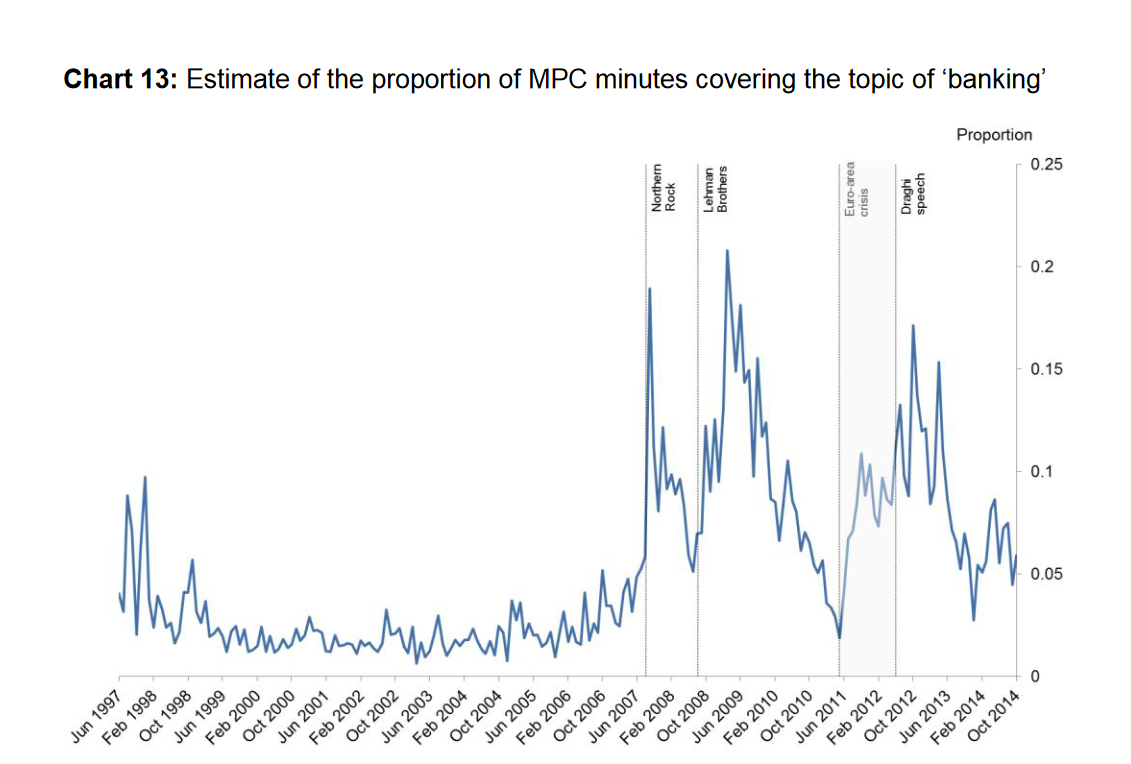

In [ ]:
# load the MPC data
data = pd.read_csv("mpc_minutes.txt", sep="\t")
data

,year,minutes
0,199706,1 Sections I to V of this minute summarise t...
1,199706,The 12-month growth rate of notes and coins ...
2,199706,"Broad money, too, decelerated in April: its ..."
3,199706,Lending growth continued at around 9% in ...
4,199706,Lending to individuals remained robust in...
...,...,...
7272,201410,"For most members, there remained insuffi..."
7273,201410,"Set against this, the level of Bank Rate..."
7274,201410,"For two members, economic circumstances ..."
7275,201410,The Governor invited the Committee to vo...


In [ ]:
data.loc[0, "minutes"]

'  1 Sections I to V of this minute summarise the analysis presented to the MPC by Bank staff and the BankÃ\x95s regional agents, and incorporate also information that became available to the Committee after the presentation but prior to the 6 June meeting.     Monetary conditions'

## Cleaning Raw Text Data

In [ ]:
# use preprocessing class
prep = apply_preprocessing(data["minutes"],      # our documents
                           "stems",              # tokens, stems or lemmas
                           "long",               # long or short
                           {},                   # dictionary with expressions we want to preserve
                           pattern,              # tokenization pattern
                           punctuation           # string with punctuation symbols to remove
                           )

In [ ]:
# inspect a particular tokenized document and compare it to its original form
i = 10
print(data["minutes"][i])
print("\n ------------------------------- \n")
print(prep.stems[i])

  There was as yet no clear downtrend in net exports. Exports to non-EU countries had risen sharply: the USA had grown very fast in Q1, but it was expected by US commentators to slow down spontaneously. Net exports to EU countries had been resilient. GDP growth in France and Germany (though not Italy) had picked up to just below trend, but domestic demand growth in those countries had been subdued.

 ------------------------------- 

['yet', 'clear', 'downtrend', 'net', 'export', 'export', 'non', 'eu', 'countri', 'risen', 'sharpli', 'usa', 'grown', 'fast', 'expect', 'comment', 'slow', 'spontan', 'net', 'export', 'eu', 'countri', 'resili', 'gdp', 'growth', 'franc', 'germani', 'though', 'itali', 'pick', 'trend', 'domest', 'demand', 'growth', 'countri', 'subdu']


In [ ]:
# generate document frequency ranking for stems
prep.get_term_ranking("stems", score_type="df")

In [ ]:
# explore top stems
prep.df_ranking["stems"][0:10]

[(3431.0, 'growth', 0),
 (3350.0, 'rate', 1),
 (3065.0, 'inflat', 2),
 (3061.0, 'month', 3),
 (2852.0, 'price', 4),
 (2767.0, 'market', 5),
 (2558.0, 'increas', 6),
 (2530.0, 'committe', 7),
 (2527.0, 'expect', 8),
 (2259.0, 'year', 9)]

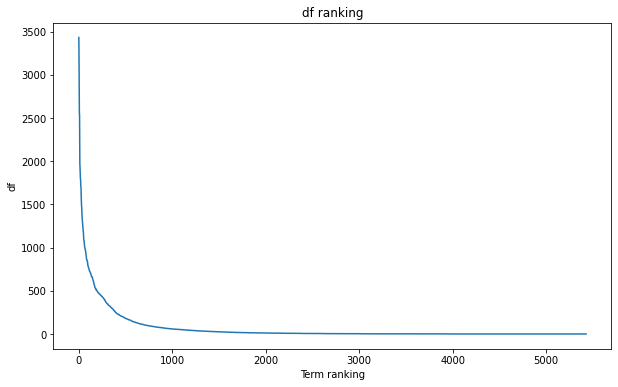

In [ ]:
# plot df ranking
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in prep.df_ranking["stems"]])
plt.title('df ranking')
plt.ylabel("df")
plt.xlabel("Term ranking")
plt.show()

In [ ]:
# generate term frequency inverse document frequency ranking of stems
prep.get_term_ranking("stems", score_type="tfidf")

In [ ]:
# explore top stems
prep.tfidf_ranking["stems"][0:10]

[(29.825243257254172, 'nfc', 0),
 (29.417855025455637, 'ip', 1),
 (28.780350233635524, 'securitis', 2),
 (28.20096850526625, 'surveya', 3),
 (28.09284413266011, 'pnfcsa', 4),
 (28.013583133605582, 'attack', 5),
 (27.89033249950207, 'bcc', 6),
 (27.731835312191592, 'egard', 7),
 (27.470589323116275, 'se', 8),
 (27.42590107664763, 'dm', 9)]

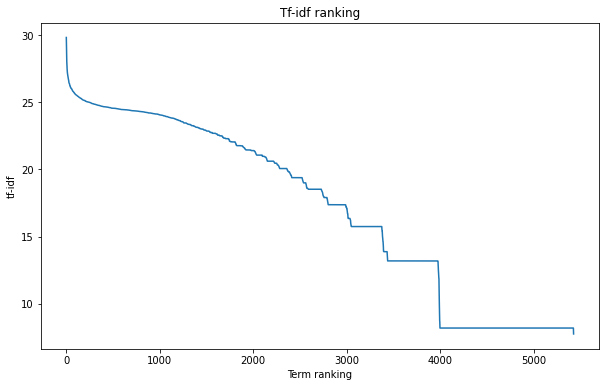

In [ ]:
# plot tfidf ranking
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in prep.tfidf_ranking["stems"]])
plt.title('Tf-idf ranking')
plt.ylabel("tf-idf")
plt.xlabel("Term ranking")
plt.show()

In [ ]:
# remove stems with a tfidf score equal or higher than the score of stem 3,600
cutoff_score = prep.tfidf_ranking["stems"][3600][0]
cutoff_score

13.19615492862266

In [ ]:
# apply removal
prep.rank_remove("stems", "tfidf", min_cutoff_score=cutoff_score)

In [ ]:
# create document-term matrix using stems
prep.dt_matrix_create(items='stems', score_type='df')
# extract document-term matrix
dt_matrix_stems = prep.df_matrix["stems"].astype(int)
print(dt_matrix_stems.shape)

(7277, 3437)


In [ ]:
# get the vocabulary and the appropriate dictionaries to map from indices to words
word2idx = prep.vocabulary["stems"]
idx2word = {i:word for word,i in word2idx.items()}

In [ ]:
all_stems = [s for d in prep.stems for s in d]
print("number of unique stems = %d" % len(set(all_stems)))
print("number of total stems = %d" % len(all_stems))

number of unique stems = 3437
number of total stems = 489523


After pre-processing, we have 3,437 unique stems We now proceed to estimate a topic model on them.

## Estimating a Topic Model

The first step in estimation is to initialize a model using the LDA class.  We will pass the list of stems we just created as the set of documents.

There are three main parameters in LDA, the number of topics, and the two hyperparameters of the Dirichlet priors.  We will follow the advice of Griffiths and Steyvers (2004) and set the hyperparameter of the Dirichlet prior on topics to $200/V$, where $V$ is the number of unique vocabulary elements, and the hyperparameter of the Dirichlet prior on document-topic distributions to $50/K$, where $K$ is the number of topics.

In [ ]:
# create LDA object with our parameters
num_topics = 30
vocab_size = dt_matrix_stems.shape[1]
lda_model = lda.LDA(n_topics=num_topics,         # Number of topics
                    alpha=50/num_topics,         # Dirichlet parameter for distribution over topics
                    eta=200/vocab_size,          # Dirichlet parameter for distribution over words
                    n_iter=5000,                 # Number of sampling iterations
                    random_state=92              # The generator used for the initial topics
                    )

lda_model

In [ ]:
# check some paramters
print(lda_model.alpha)
print(lda_model.eta)
print(lda_model.n_topics)

1.6666666666666667
0.05819028222286878
30


In [ ]:
# estimate model (takes around 7 minutes)
lda_model.fit(dt_matrix_stems)

In [ ]:
# topics: probability distribution over the vocabulary (num_topics x vocab_size)
lda_model.topic_word_.shape

(30, 3437)

In [ ]:
# explore the words with highest probability per topic
topics_dist = lda_model.topic_word_
n_top_words = 15
for i, topic_dist in enumerate(topics_dist):
    top_idxs = np.argsort(topic_dist)[:-n_top_words:-1]
    top_words = [idx2word[idx] for idx in top_idxs]
    print('Topic {}: {}'.format(i, ' '.join(top_words)))

Topic 0: risk member outlook balanc downsid view medium upsid target differ weight near prospect uncertainti
Topic 1: unit euro area state kingdom countri govern germani european concern posit fiscal german elsewher
Topic 2: world global econom activ prospect slowdown affect recoveri possibl outlook emerg equiti uk financi
Topic 3: employ labour unemploy measur survey work lfs job part number hour time forc claimant
Topic 4: novemb januari decemb fallen februari octob point previous index risen slight declin earlier level
Topic 5: oil higher import reflect suppli commod pressur futur produc input energi effect impact factor
Topic 6: cpi reflect near line ahead higher impact time pre come twelv energi around committeea
Topic 7: monetari target medium set current condit committeea agre stimulus time provid tighten meet financi
Topic 8: littl seem news weaker appear stronger consist evid look broad somewhat grow although sign
Topic 9: august fallen juli septemb previous index octob risen 

In [ ]:
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
n_top_words = 15
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=n_top_words,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

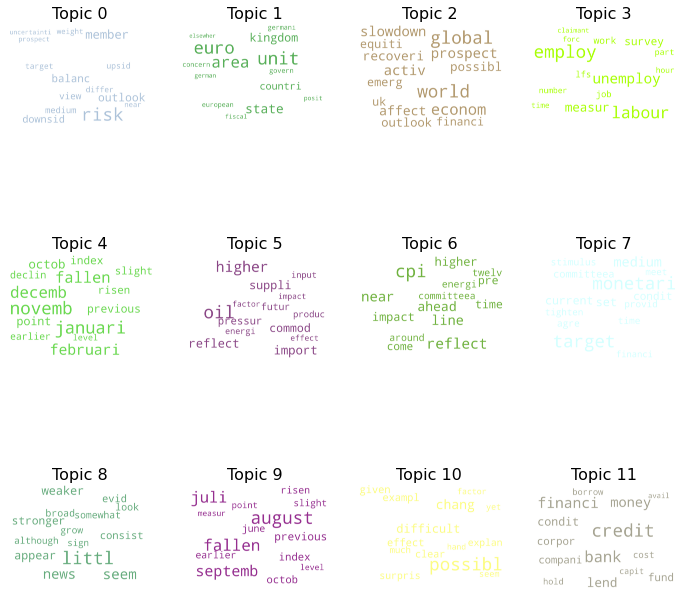

In [ ]:
# create figure
fig, axes = plt.subplots(3, 4, figsize=(12,12), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    
    # select top words from topic
    topic_dist = topics_dist[i]
    top_idxs = np.argsort(topic_dist)[:-n_top_words:-1]
    top_words = [idx2word[idx] for idx in top_idxs]
    top_probs = [topic_dist[idx] for idx in top_idxs]
    plot_dict = {top_words[i]:top_probs[i] for i in range(len(top_words))}

    # generate subplot    
    fig.add_subplot(ax)
    cloud.generate_from_frequencies(plot_dict, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

In this particular topic model, topic 11 appears to be about banking and financial markets.


In [ ]:
n_top_words = 20
topic_dist = topics_dist[11]
top_idxs = np.argsort(topic_dist)[:-n_top_words:-1]
top_words = [idx2word[idx] for idx in top_idxs]
print('Topic {}: {}'.format(11, ' '.join(top_words)))

Topic 11: credit bank financi money lend condit fund corpor compani cost borrow hold capit avail non broad secur spread household


## Querying Using Estimated Topics

In [ ]:
# replace the speech field in the original data with its cleaned and stemmed version
data['minutes_stems'] = [' '.join(s) for s in prep.stems] 

# aggregate up to the year-speech level using the stemmed version of the speech
agg_minutes = data.groupby(['year'], as_index = False)['minutes_stems'].apply(lambda x: ' '.join(x)) 
agg_minutes

,year,minutes_stems
0,199706,section minut summaris analysi present mpc ban...
1,199707,section minut summaris analysi present mpc ban...
2,199708,section minut summaris analysi present mpc ban...
3,199709,meet took place background earlier present ban...
4,199710,inut mpc meet octob meet preced present bank s...
...,...,...
204,201406,turn immedi decis discuss financi develop inte...
205,201407,turn immedi decis discuss financi develop inte...
206,201408,turn immedi decis backdrop latest project disc...
207,201409,turn immedi decis discuss financi develop inte...


In [ ]:
# simple auxiliary function to override the preprocessing done by sklearn
def do_nothing(doc):
    return doc

# generate document-term matrix of agreggated speeches
count_vectorizer = CountVectorizer(preprocessor=do_nothing,              # apply no additional preprocessing
                                   token_pattern=pattern,                # use same tokenization pattern
                                   lowercase=False,                      # convert all characters to lower-case
                                   strip_accents=None,                   # remove non-ascii characters
                                   stop_words=None,                      # remove stopwords from a built-in list. We can also provide our own list
                                   vocabulary=word2idx                   # impose same vocabulary
                                   )                       
count_vectorizer

CountVectorizer(lowercase=False,
                preprocessor=<function do_nothing at 0x7fb013e30d40>,
                vocabulary={'ab': 0, 'abandon': 1, 'abat': 2, 'abcp': 3,
                            'abil': 4, 'abl': 5, 'abnorm': 6, 'abolit': 7,
                            'abour': 8, 'abroad': 9, 'abrupt': 10, 'absenc': 11,
                            'absent': 12, 'absolut': 13, 'absorb': 14,
                            'absorpt': 15, 'abstract': 16, 'academ': 17,
                            'acceler': 18, 'accentu': 19, 'accept': 20,
                            'access': 21, 'accommod': 22, 'accompani': 23,
                            'accord': 24, 'account': 25, 'accru': 26,
                            'accumul': 27, 'accur': 28, 'accuraci': 29, ...})

In [ ]:
# create the document-term matrix using stems
dt_matrix_stems_agg = count_vectorizer.fit_transform(agg_minutes["minutes_stems"].values).toarray()
print(dt_matrix_stems_agg.shape)
# extract the vocabulary
vocab_agg = count_vectorizer.vocabulary_

(209, 3437)


In [ ]:
# transform documents into their topic proportions
topic_proportions = lda_model.transform(dt_matrix_stems_agg,
                                        max_iter=20
                                        )
topic_proportions.shape

(209, 30)

Finally, we follow similar steps as for LDA to output the estimated distribution of topics for entire speeches.

In [ ]:
# add the topic proportions to each document
for i in range(topic_proportions.shape[1]): agg_minutes['T' + str(i)] = topic_proportions[:,i]

In [ ]:
# explore new data
agg_minutes.head(5)

,year,minutes_stems,T0,T1,T2,T3,T4,T5,T6,T7,...,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29
0,199706,section minut summaris analysi present mpc ban...,0.028211,0.004472,0.003669,0.030774,0.009851,0.021888,0.017512,0.016753,...,0.027675,0.021062,0.052823,0.092026,0.021465,0.028620,0.036539,0.026306,0.164235,0.008570
1,199707,section minut summaris analysi present mpc ban...,0.006235,0.008282,0.006282,0.045379,0.007732,0.027316,0.019255,0.014691,...,0.018648,0.046736,0.036250,0.069049,0.021240,0.034429,0.028294,0.078163,0.151987,0.013384
2,199708,section minut summaris analysi present mpc ban...,0.029253,0.011982,0.004784,0.053379,0.005755,0.025502,0.007956,0.024378,...,0.018549,0.046353,0.032877,0.029457,0.030611,0.029424,0.029145,0.062468,0.173307,0.011094
3,199709,meet took place background earlier present ban...,0.022396,0.003722,0.004266,0.027622,0.000681,0.024324,0.016024,0.013887,...,0.049590,0.014857,0.024703,0.012850,0.030238,0.011424,0.027469,0.054114,0.164196,0.019375
4,199710,inut mpc meet octob meet preced present bank s...,0.013838,0.009212,0.003536,0.048468,0.006237,0.028346,0.018533,0.019852,...,0.016025,0.041085,0.055440,0.007322,0.023959,0.010220,0.030508,0.015319,0.223191,0.014982


In [ ]:
# save data
agg_minutes.to_csv("final_output_agg.csv", index=False)

In [ ]:
# clean date format
agg_minutes["year_clean"] = pd.to_datetime(agg_minutes["year"], format="%Y%m")
agg_minutes

,year,minutes_stems,T0,T1,T2,T3,T4,T5,T6,T7,...,T21,T22,T23,T24,T25,T26,T27,T28,T29,year_clean
0,199706,section minut summaris analysi present mpc ban...,0.028211,0.004472,0.003669,0.030774,0.009851,0.021888,0.017512,0.016753,...,0.021062,0.052823,0.092026,0.021465,0.028620,0.036539,0.026306,0.164235,0.008570,1997-06-01
1,199707,section minut summaris analysi present mpc ban...,0.006235,0.008282,0.006282,0.045379,0.007732,0.027316,0.019255,0.014691,...,0.046736,0.036250,0.069049,0.021240,0.034429,0.028294,0.078163,0.151987,0.013384,1997-07-01
2,199708,section minut summaris analysi present mpc ban...,0.029253,0.011982,0.004784,0.053379,0.005755,0.025502,0.007956,0.024378,...,0.046353,0.032877,0.029457,0.030611,0.029424,0.029145,0.062468,0.173307,0.011094,1997-08-01
3,199709,meet took place background earlier present ban...,0.022396,0.003722,0.004266,0.027622,0.000681,0.024324,0.016024,0.013887,...,0.014857,0.024703,0.012850,0.030238,0.011424,0.027469,0.054114,0.164196,0.019375,1997-09-01
4,199710,inut mpc meet octob meet preced present bank s...,0.013838,0.009212,0.003536,0.048468,0.006237,0.028346,0.018533,0.019852,...,0.041085,0.055440,0.007322,0.023959,0.010220,0.030508,0.015319,0.223191,0.014982,1997-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,201406,turn immedi decis discuss financi develop inte...,0.020842,0.039586,0.020633,0.033259,0.007995,0.013609,0.046794,0.039450,...,0.024272,0.041993,0.057611,0.058831,0.020140,0.041158,0.020780,0.018313,0.074607,2014-06-01
205,201407,turn immedi decis discuss financi develop inte...,0.021161,0.025742,0.030928,0.062910,0.010720,0.015638,0.033410,0.059200,...,0.023093,0.038165,0.047212,0.068151,0.009599,0.043697,0.021953,0.013119,0.055904,2014-07-01
206,201408,turn immedi decis backdrop latest project disc...,0.024718,0.034327,0.046033,0.061124,0.002099,0.011823,0.038091,0.065274,...,0.026063,0.029233,0.021802,0.061716,0.018148,0.021567,0.022437,0.016218,0.080855,2014-08-01
207,201409,turn immedi decis discuss financi develop inte...,0.027464,0.062754,0.037346,0.055722,0.004621,0.022008,0.038939,0.060284,...,0.018812,0.047019,0.009604,0.062381,0.006753,0.035029,0.015970,0.017595,0.060106,2014-09-01


[]

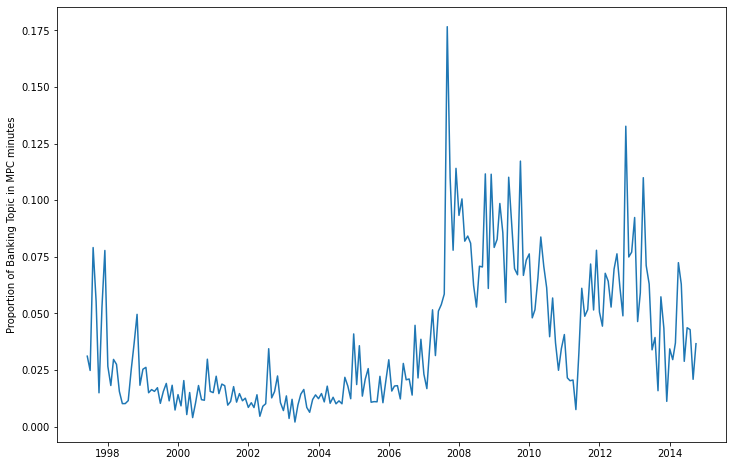

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(agg_minutes.year_clean.values, agg_minutes.T11.values)
plt.ylabel("Proportion of Banking Topic in MPC minutes")
plt.plot()